# Age, FC, PC - Test LASSO on age
Estimate features on 20x bootstrap (train: 350, test: 150)
Use top (2,10,50,100,200) connections on (train: 200, test: 130)

In [1]:
# Using newly preprocessed subjects

import pickle

metadictname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_agesexwrat.pkl'
alltsname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_PowerTS_float2.pkl'

with open(metadictname, 'rb') as f:
    metadict = pickle.load(f)

with open(alltsname, 'rb') as f:
    allts = pickle.load(f)
    
print(list(metadict.keys()))
print(list(allts.keys()))
print('Complete')

['age', 'sex', 'wrat', 'missingage', 'missingsex', 'missingwrat', 'failedqc']
['emoid', 'nback', 'rest']
Complete


In [2]:
'''
Get subjects that have all tasks and paras specified
Functions for creating independent and response variables
'''

import numpy as np
from natsort import natsorted

def get_subs(allts, metadict, tasks, paras):
    # Get subs for all paras
    for i,para in enumerate(paras):
        tmpset = set([int(sub[4:]) for sub in allts[para].keys()])
        if i == 0:
            paraset = tmpset
        else:
            paraset = paraset.intersection(tmpset)
    # Get subs for all tasks
    for i,task in enumerate(tasks):
        tmpset = set([sub for sub in metadict[task].keys()])
        if i == 0:
            taskset = tmpset
        else:
            taskset = paraset.intersection(tmpset)
    # Remove QC failures
    allsubs = taskset.intersection(paraset)
    for badsub in metadict['failedqc']:
        try:
            allsubs.remove(int(badsub[4:]))
        except:
            pass
    return natsorted(list(allsubs))

def get_X(allts, paras, subs):
    X = []
    for para in paras:
        pX = [allts[para][f'sub-{sub}'] for sub in subs]
        pX = np.stack(pX)
        X.append(pX)
    return X

def get_y(metadict, tasks, subs):
    y = []
    for task in tasks:
        if task == 'age' or task == 'wrat':
            var = [metadict[task][sub] for sub in subs]
            var = np.array(var)
            y.append(var)
        if task == 'sex':
            maleness = [metadict[task][sub] == 'M' for sub in subs]
            maleness = np.array(maleness)
            sex = np.stack([maleness, 1-maleness], axis=1)
            y.append(sex)
    return y

subs = get_subs(allts, metadict, ['wrat'], ['rest', 'nback', 'emoid'])
print(len(subs))

X = get_X(allts, ['rest', 'nback', 'emoid'], subs)
print(X[0].shape)

830
(830, 264, 124)


In [3]:
# TS to condensed FC

from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 3

def filter_design_ts(X):
    Xs = []
    for i in range(X.shape[0]):
        nX = butter_bandpass_filter(X[i], [0.01, 0.15], 1/tr)
        Xs.append(nX)
    return np.stack(Xs)

def ts_to_flat_fc(X):
    p = np.corrcoef(X)
    a,b = np.triu_indices(p[0].shape[0], 1)
    p = p[a,b]
    return p

p = [np.stack([ts_to_flat_fc(ts) for ts in filter_design_ts(Xp)]) for Xp in X]
# Xfiltnorm = [tsmod/np.linalg.norm(tsmod, axis=(-1), keepdims=True) for tsmod in ts]
print(p[0].shape)

(830, 34716)


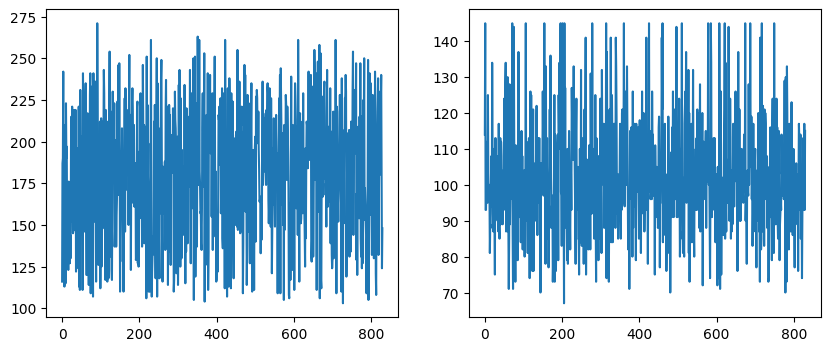

In [8]:
# Check if original distribution of subjects is okay

import matplotlib.pyplot as plt

y = get_y(metadict, ['age', 'wrat'], subs)

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(y[0])
ax[1].plot(y[1])
fig.show()

In [4]:
# Get all partial correlations

from nilearn.connectome import ConnectivityMeasure

cm = ConnectivityMeasure(kind='partial correlation')

a,b = np.triu_indices(264, 1)

allp = []
for taskidx in range(3):
    Xf = filter_design_ts(X[taskidx])
    partials = cm.fit_transform(Xf.transpose(0,2,1))
    partials = partials[:,a,b]
    allp.append(partials)
    print('Done partials')

allp = np.stack(allp)
print(allp.shape)

Done partials
Done partials
Done partials
(3, 830, 34716)


In [61]:
from sklearn.linear_model import Lasso

task = 'age'
para = 'nback'
para_idx = 1
ntrain = 350
# stop = 12*12

def rmse(a,b):
    r = np.mean((a-b)**2)**0.5
    return float(r)

wrs = []
allrmse = []

for i in range(20):
    idcs = np.random.permutation(500)
    x = allp[para_idx]
    x = x[idcs]
    xtr = x[:ntrain]
    xt = x[ntrain:]

    mux = np.mean(xtr, axis=0, keepdims=True)
    sigx = np.std(xtr, axis=0, keepdims=True)
    xtr = xtr - mux
    xt = xt - mux

    y = get_y(metadict, [task], subs)[0]
    y = y[idcs]
    ytr = y[:ntrain]
    yt = y[ntrain:]

    mu = np.mean(ytr)
    ytr = ytr - mu
    yt = yt - mu

    clf = Lasso(alpha=0.1).fit(xtr, ytr)
    yhat = clf.predict(xt)

    r = rmse(yhat, yt)
    print(r)

    w = clf.coef_
    wrs.append(w*np.mean(x, axis=0))
    
    allrmse.append(r)
    
wrs = np.stack(wrs)
print(wrs.shape)
print(np.mean(np.array(allrmse)))

31.872912746920814
28.682081507311302
29.452036890858622
30.230974354502308
28.678340328438154
30.734395110274157
29.14102884703403
32.18751667893171
31.337625575598512
29.23086253775722
30.28598406254861
29.165633897755228
32.34146565869013
32.26722040315376
28.57661539084349
32.60862846428753
28.372588440641834
29.43972444914894
30.410877700493977
32.54527696864707
(20, 34716)
30.378089500691868


In [51]:
import matplotlib.pyplot as plt

ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45, 
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85, 
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132, 
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186, 
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257, 
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,  
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248, 
249, 252, 253]

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

def label(idcs, labtype='raw'):
    if labtype == 'raw':
        return [str(idx) for idx in idcs]
    if labtype == 'rois':
        return [f'{rois_a[idx]}-{rois_b[idx]}' for idx in idcs]
    if labtype == 'fns':
        fns = []
        for idx in idcs:
            a, b = rois_a[idx], rois_b[idx]
            fns.append(f'{fn_names_map[a]}-{fn_names_map[b]}')
        return fns

def d_from_vec(fc):
    n = fc.size
    return int(round((1+(1+8*n)**0.5)/2))

def make_fn_map(bounds):
    fnidx = 0
    bmap = dict()
    for i in range(264):
        if i >= bounds[fnidx]:
            fnidx += 1
        bmap[i] = fnidx
    return bmap

bounds = [30, 35, 49, 62, 120, 125, 156, 181, 199, 212, 221, 232, 236, 264]
fn_map = make_fn_map(bounds)

fn_names = 'SMT,SMH,CNG,AUD,DMN,MEM,VIS,FRNT,SAL,SUB,VATN,DATN,CB,UNK'.split(',')
fn_names_map = {idx: fn_names[fn] for idx,fn in fn_map.items()}

rois_a, rois_b = np.triu_indices(264,1)


def vec2mat(fc, fillones=True):
    d = d_from_vec(fc)
    a,b = np.triu_indices(d,1)
    mat = np.zeros((d,d))
    mat[a,b] = fc
    mat += mat.T
    ones = np.arange(d)
    if fillones:
        mat[ones,ones] = 1
    return mat

def mat2vec(fc):
    d = fc.shape[0]
    a,b = np.triu_indices(d,1)
    return fc[a,b]

wr = np.mean(wrs, axis=0)
# wr = mat2vec(remap(vec2mat(wr, False)))
fidcs = np.argsort(np.abs(wr))

print(fidcs[:-20:-1])

# labs1 = label(fidcs[:-11:-1], 'fns')
# labs2 = label(fidcs[:-11:-1], 'rois')
# labs = [f"{aa}\n{bb}" for aa,bb in zip(labs1,labs2)]

# fig, ax = plt.subplots()
# ax.bar(np.arange(10), height=wr[fidcs[:-11:-1]], tick_label=labs)
# ax.tick_params(axis='x', labelrotation=-60)
# fig.show()

[34015 25319 33896 28942  5798  4355  5565 26966 26287 31395 24986 29772
 25543 27048     0  9964 27814 32438 20855]


In [53]:
from sklearn.linear_model import LinearRegression

ntrain = 200

allrmse = []

for i in range(20):
    idcs = np.random.permutation(330)
    x = allp[para_idx][500:]
    x = x[idcs,:]
    x = x[:,fidcs[:-3:-1]]
    xtr = x[:ntrain]
    xt = x[ntrain:]

    mux = np.mean(xtr, axis=0, keepdims=True)
    sigx = np.std(xtr, axis=0, keepdims=True)
    xtr = xtr - mux
    xt = xt - mux

    y = get_y(metadict, [task], subs)[0]
    y = y[500:]
    y = y[idcs]
    ytr = y[:ntrain]
    yt = y[ntrain:]

    mu = np.mean(ytr)
    ytr = ytr - mu
    yt = yt - mu

    clf = LinearRegression().fit(xtr, ytr)
    yhat = clf.predict(xt)

    r = rmse(yhat, yt)
    allrmse.append(r)
    
print('---')
print(np.mean(np.array(allrmse)))

---
32.58272205903246


In [145]:
# Split into train and test

import torch
import torch.nn as nn
import torch.nn.functional as F

task = 'wrat'
para = 'emoid'
para_idx = 2
ntrain = 350
stop = 12*12

# Summary:

rmse_lstsq = []
rmse_mlp = []
rmse_latsim = []

mse = nn.MSELoss()

# Saving

def save(task, para, model, i, w, trsubs, tsubs, rmse):
    fname = f'../../Work/ImageNomer/fc-{task}/{model}-{para}{i}.pkl'
    desc = f'{task} prediction full model {model} fc rmse: {rmse}'
    dct = dict(w=w.detach().cpu().numpy(), trsubs=trsubs, tsubs=tsubs, desc=desc)
    with open(fname, 'wb') as f:
        pickle.dump(dct, f)
    print(f'Saved {fname}')
    
for i in range(20):
    print(f'Iteration {i}........')

    idcs = np.random.permutation(500)
    x = p[para_idx]
    x = x[idcs]
    xtr = x[:ntrain]
    xt = x[ntrain:]

    mux = np.mean(xtr, axis=0, keepdims=True)
    sigx = np.std(xtr, axis=0, keepdims=True)
    xtr = xtr - mux
    xt = xt - mux

    y = get_y(metadict, [task], subs)[0]
    y = y[idcs]
    ytr = y[:ntrain]
    yt = y[ntrain:]

    mu = np.mean(ytr)
    ytr = ytr - mu
    yt = yt - mu

    xxtr = torch.from_numpy(xtr).float().cuda()
    xxt = torch.from_numpy(xt).float().cuda()

    yytr = torch.from_numpy(ytr).float().cuda()
    yyt = torch.from_numpy(yt).float().cuda()

    print([z.shape for z in [xtr, xt, ytr, yt]])

    # Least squares

    w,_,_,_ = torch.linalg.lstsq(xxtr, yytr)

    yhat = xxt@w

    rmse = mse(yhat, yyt)**0.5
    rmse = float(rmse)
    print(rmse)
    rmse_lstsq.append(rmse)
    save(task, para, 'lstsq', i, w, subs[:ntrain], subs[ntrain:], rmse)

    # MLP

    class MLP(nn.Module):
        def __init__(self, d):
            super(MLP, self).__init__()
            self.fc1 = nn.Linear(d,40).float().cuda()
            self.fc2 = nn.Linear(40,1).float().cuda()

        def l1(self):
            return torch.mean(torch.abs(self.fc1.weight))

        def forward(self, x):
            x = F.relu(self.fc1(x))
            return self.fc2(x).squeeze()

    nepochs = 3000
    pperiod = 200

    mlp = MLP(xxtr.shape[1])

    # Optimizers
    optim = torch.optim.Adam(mlp.parameters(), lr=1e-4, weight_decay=1e-4)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=20, factor=0.75, eps=1e-7)

    for epoch in range(nepochs):
        optim.zero_grad()
        yhat = mlp(xxtr)
        loss = mse(yhat, yytr)
        loss.backward()
        optim.step()
        if loss < stop:
            break
        sched.step(loss)
        if epoch % pperiod == 0 or epoch == nepochs-1:
            print(f'{epoch} recon: {[float(ls)**0.5 for ls in [loss]]} '
                 f'lr: {sched._last_lr}')

    print('Complete')

    yhat = mlp(xxt)
    rmse = mse(yhat, yyt)**0.5
    rmse = float(rmse)
    print(rmse)
    rmse = float(rmse)
    rmse_mlp.append(rmse)
    save(task, para, 'mlp', i, torch.mean(torch.abs(mlp.fc1.weight), dim=0), subs[:ntrain], subs[ntrain:], rmse)

    # LatSim

    class LatSim(nn.Module):
        def __init__(self, d, ld=2):
            super(LatSim, self).__init__()
            self.A = nn.Parameter((torch.randn(d,ld)/(d**0.5)).float().cuda())

        def E(self, xtr, xt=None):
            AT = (xtr@self.A).T
            if xt is not None:
                A = xt@self.A
            else:
                A = AT.T
            E = A@AT
            return F.softmax(E,dim=1)

        def l1(self):
            return torch.mean(torch.abs(self.A))

        def forward(self, xtr, xt, ytr):
            E = self.E(xtr, xt)
            return E@ytr

    latsim = LatSim(xxtr.shape[1], ld=2)

    nepochs = 3000
    pperiod = 200

    # Optimizers
    optim = torch.optim.Adam(latsim.parameters(), lr=1e-4, weight_decay=0)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=20, factor=0.75, eps=1e-7)

    for epoch in range(nepochs):
        optim.zero_grad()
        yhat = latsim(xxtr, xxtr, yytr)
        loss = mse(yhat, yytr)
        loss.backward()
        optim.step()
        if loss < stop:
            break
        sched.step(loss)
        if epoch % pperiod == 0 or epoch == nepochs-1:
            print(f'{epoch} recon: {[float(ls)**0.5 for ls in [loss]]} lr: {sched._last_lr}')

    print('Complete')

    yhat = latsim(xxtr, xxt, yytr)
    rmse = mse(yhat, yyt)**0.5
    rmse = float(rmse)
    print(rmse)
    rmse_latsim.append(rmse)
    save(task, para, 'latsim', i, torch.mean(torch.abs(latsim.A), dim=1), subs[:ntrain], subs[ntrain:], rmse)

Iteration 0........
[(350, 34716), (150, 34716), (350,), (150,)]
15.729079246520996
Saved ../../Work/ImageNomer/fc-wrat/lstsq-emoid0.pkl
0 recon: [16.048052156799084] lr: [0.0001]
Complete
15.357000350952148
Saved ../../Work/ImageNomer/fc-wrat/mlp-emoid0.pkl
0 recon: [16.04954011917816] lr: [0.0001]
Complete
15.361047744750977
Saved ../../Work/ImageNomer/fc-wrat/latsim-emoid0.pkl
Iteration 1........
[(350, 34716), (150, 34716), (350,), (150,)]
17.74887466430664
Saved ../../Work/ImageNomer/fc-wrat/lstsq-emoid1.pkl
0 recon: [15.493464907307995] lr: [0.0001]
Complete
16.86155128479004
Saved ../../Work/ImageNomer/fc-wrat/mlp-emoid1.pkl
0 recon: [15.48788815705452] lr: [0.0001]
Complete
17.117904663085938
Saved ../../Work/ImageNomer/fc-wrat/latsim-emoid1.pkl
Iteration 2........
[(350, 34716), (150, 34716), (350,), (150,)]
17.337980270385742
Saved ../../Work/ImageNomer/fc-wrat/lstsq-emoid2.pkl
0 recon: [15.929348884489569] lr: [0.0001]
Complete
15.699128150939941
Saved ../../Work/ImageNomer/

In [146]:
for rmse in [rmse_lstsq, rmse_mlp, rmse_latsim]:
    rmse = np.array(rmse)
    print(np.mean(rmse), np.std(rmse))

16.32335090637207 0.7775157364487056
15.739857721328736 0.6532870772706406
15.847862005233765 0.7478874907132247
